# Task 1: Explore  Simulated Muon Data  

We begin with a simplified Monte Carlo (MC) dataset containing muons simulated within the PDHD detector.

Familiarize yourself with the data format and event displays to develop an intuitive understanding of the dataset.

- Create plots and analyze features to interpret activity in each readout plane.
- Identify and distinguish different event topologies (how does the signature of the track change with direction?).
- Examine how Trigger Primitive (TP) properties vary between events and consider possible reasons.
- Compare the response observed in the **collection plane (plane 2)** with that in the **induction planes (planes 0 and 1)**.

As you explore, consider the detector geometry and readout characteristics. Verify whether the observed data behavior aligns with the detector design and expected physical response. Also, note any indications of noise within the data.


# Example code to load detector/simulation data into the notebook for analysis

In [1]:
import uproot
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
# %matplotlib widget 
warnings.filterwarnings('ignore')


def load_data(filepath, branch_names, max_events=3000):
    """Load data from a ROOT file into a pandas DataFrame."""
    try:
        with uproot.open(filepath) as file:
            tree = file["triggerana/tree"]
            arrays = tree.arrays(branch_names, library="ak", entry_stop=max_events)
            return ak.to_dataframe(arrays)
    except Exception as e:
        print(f"Error loading data from {filepath}: {e}")
        return None

# name of branches in the TTree to read into the pandas df
TP_BRANCHES = ["event", "TP_channel", "TP_startT", "TP_peakT", "TP_peakADC", "TP_SADC", "TP_TOT", "TP_plane", "TP_TPC",] #visible signal  - trigger primitives 

#MC-specific branches
MC_BRANCHES = ["event", "Eng", "Px", "Py", "Pz", "P"] #MC information from the particle  (only to be used for simulated data)



#Load data 
#--simulation data containing 100 single muon events in the ProtoDUNE Horizontal Drift Geometry (PDHD)
mc  = load_data("data/muons_simtps_pdhd_n100.root", MC_BRANCHES, 1000) #Some of the monte carlo output containing information about the energy & momentum of the muon in each event 
tps  = load_data("data/muons_simtps_pdhd_n100.root", TP_BRANCHES, 1000)  #corresponding trigger primitive (TP) information - this is the data we see within the detector 



## Getting a Feel for the Data  : Simple Global Plots to Start With


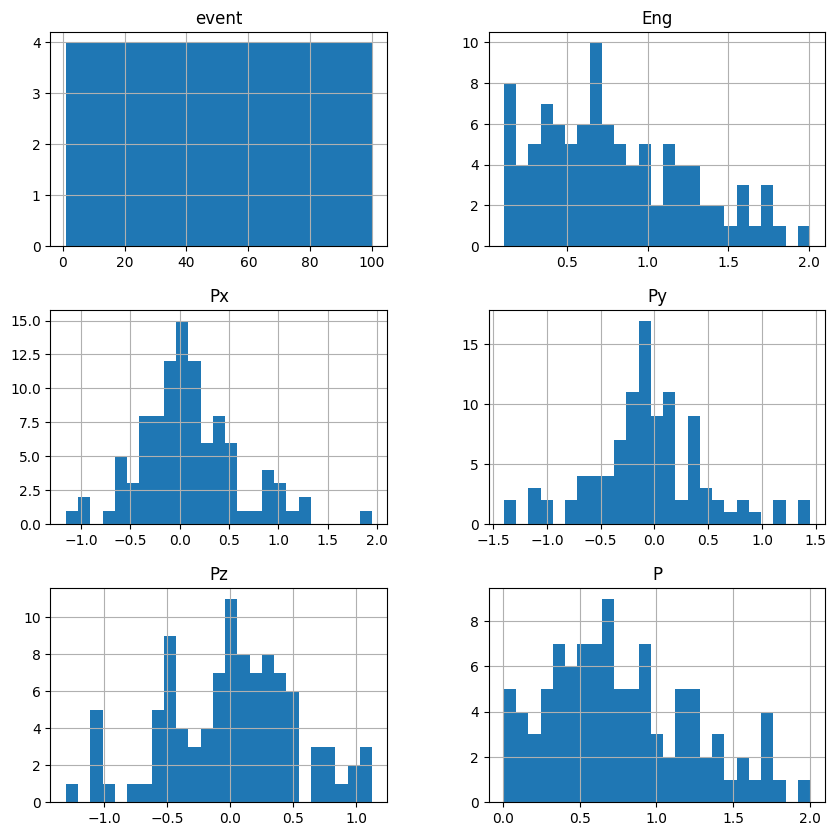

In [2]:
#MC data - note that the energies are in GeV
mc.hist(figsize= (10,10), bins =25)
plt.show()



In [3]:
#let's also look at the data frames to familiarise with the structure
mc.head()

,,event,Eng,Px,Py,Pz,P
entry,subentry,,,,,,
0,0,1,0.218716,-0.013635,0.062382,0.180543,0.191502
1,0,2,0.543898,-0.248281,0.344831,0.322659,0.533536
2,0,3,0.931950,0.005019,0.779852,-0.499173,0.925941
3,0,4,0.107075,-0.008494,-0.010731,-0.010682,0.017361
4,0,5,1.691671,1.217868,-0.433145,1.086172,1.688369


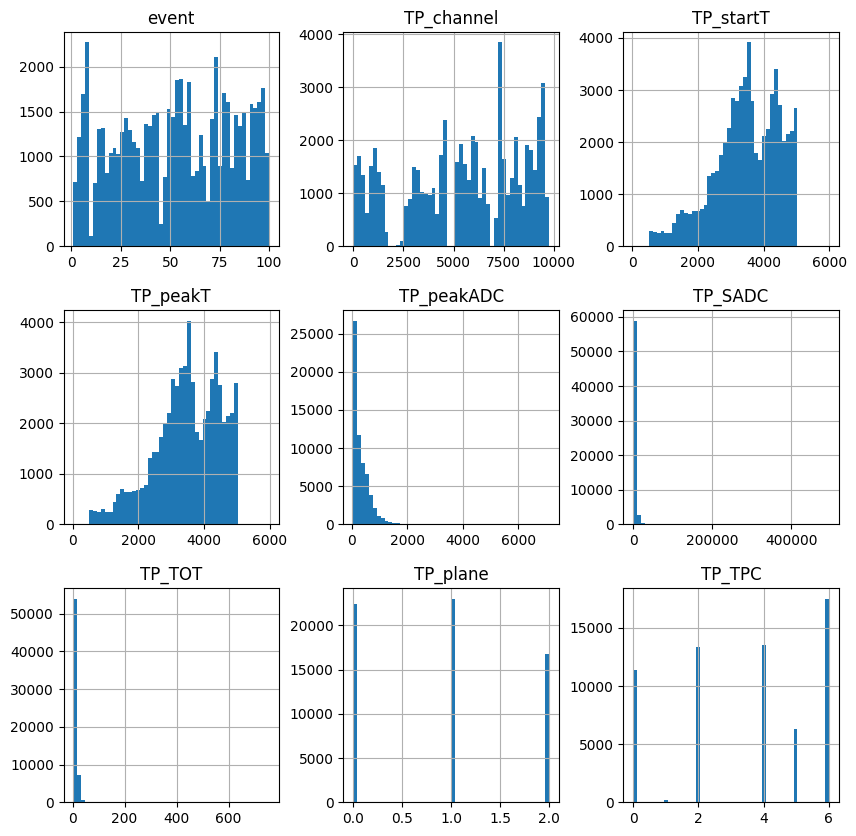

In [4]:
#TP data 
tps[tps.TP_TOT>2].hist(figsize= (10,10), bins =50)
plt.show()

In [5]:
#and print the dataframe
tps.head()

event  TP_channel  TP_startT  TP_peakT  TP_peakADC  TP_SADC  \
entry subentry                                                                
0     0             1           0       2737      2737          61       61   
      1             1          33       5775      5775          63       63   
      2             1          70       5218      5219          67      131   
      3             1          82       2025      2025          61       61   
      4             1          93       4348      4349          66      127   

                TP_TOT  TP_plane  TP_TPC  
entry subentry                            
0     0              1         0       0  
      1              1         0       0  
      2              2         0       0  
      3              1         0       0  
      4              2         0       0

# Event display 
## Let's have a look at how the events look within the detector

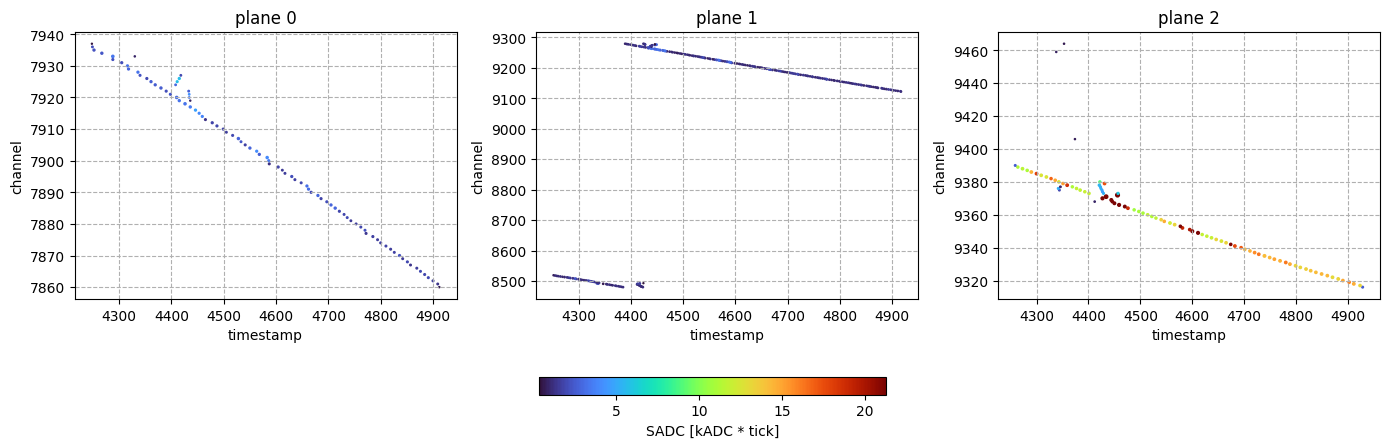

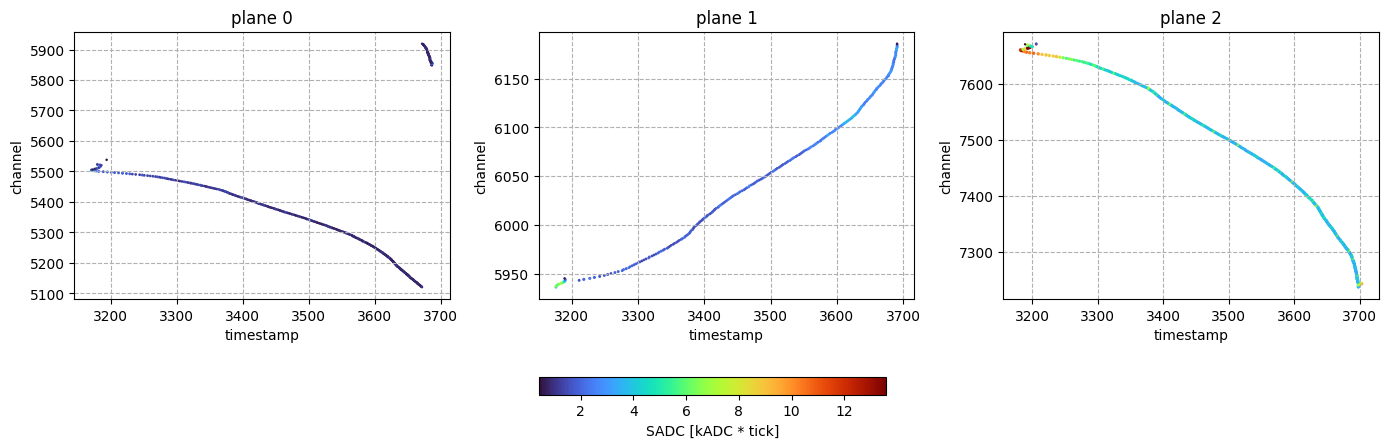

In [6]:
def PlotData(df, event, hit_threshold = 80):
    '''
    A function that let's you plot the trajectory of the muon in time-channel space, as seen within the detector
    increase the hit finding threshold if you're seeing noise in the data
    '''

    tps_all = df[(df.event == event)  & (df.TP_peakADC > hit_threshold)]
    vmin, vmax = tps_all["TP_SADC"].min()/1e3, (tps_all["TP_SADC"].max()/1e3)/2

    fig, ax = plt.subplots(1, 3, figsize=(14, 4.5))

    for plane in range(3):
        tps = tps_all[tps_all.TP_plane == plane]
        sc = ax[plane].scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='turbo', vmin=vmin, vmax=vmax)
        ax[plane].set_xlabel("timestamp")
        ax[plane].set_ylabel("channel")
        ax[plane].set_title(f"plane {plane}")
        ax[plane].grid(linestyle='dashed')

    fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.05, pad=-0.3).set_label("SADC [kADC * tick]")
    plt.tight_layout()
    plt.show()

PlotData(tps, 92)
PlotData(tps, 91)



# Task 2: Beyond Basic Exploration  

Once you're comfortable exploring the basic features of the data, you can start to perform more detailed analyses. This means looking for patterns, correlations, and insights that aren't immediately obvious from just one variable or plot.

### Example: Correlating Muon Energy with TP Activity  

One useful direction is to study how the energy of the muon correlates with the total visible energy recorded by the TPs, particularly in the **collection plane (plane 2)**, which is often the most signal-rich. Here's a step-by-step  example of how you can process the data and make associations between the TP and MC information based on event ID: 

```python


# Select only Trigger Primitives from the collection plane (plane ID == 2)
tp_plane2 = tps[tps.TP_plane == 2]

# Identify unique event IDs that have activity in plane 2
# (This helps exclude events where the muon left the detector without passing through the active volume - hence producing no visible energy)
events_with_tp_activity = tp_plane2['event'].unique()

# From the MC dataset, select only those events that had visible TP activity and extract the corresponding muon energy values
muon_energy = mc[mc['event'].isin(events_with_tp_activity)].set_index('event')['Eng']

# Sum up the energy from all the collection TPs for each event 
visible_energy = tp_plane2.groupby('event')['TP_SADC'].sum() 


# Plot the correlation
plt.figure(figsize=(8, 6))
plt.scatter(muon_energy, visible_energy, s=20, c='k', marker='s')
plt.xlabel("Muon Energy [GeV]")
plt.ylabel("Visible Energy from Collection TPs [ADC]")
plt.title("Correlation Between Muon Energy and TP Activity (Plane 2)")
plt.grid(True)
plt.tight_layout()
plt.show()


```
### Try the code above and see if it makes sense to you! Does the plot look like you would expect it to? Can you compare the visible energy in the other planes? 

# Task 3: Analysis of Real Data from the PDHD Detector

Once you're comfortable with the simplified MC data, the next step is to analyze real data collected by the ProtoDUNE Horizontal Drift (PDHD) detector.


As a surface detector, PDHD is continuously bombarded by cosmic rays, resulting in multiple overlapping tracks within each recorded event. Compared to the previous data, we can expect:
- Increased complexity due to pile-up of simultaneous activity,
- More variable noise levels compared to MC simulations, and noisy/dead channels (which can change across multiple trigger records, as the data taking conditions are never exactly the same!)

## Objectives

- Load and examine the PDHD data using similar metrics as for MC (e.g., TP distributions, energy sums).
- Compare event characteristics between real data and MC, noting differences in noise, event complexity, and signal features.
- Try to extract meaningful features such as total visible energy, TP counts, and spatial or temporal distributions (where possible).


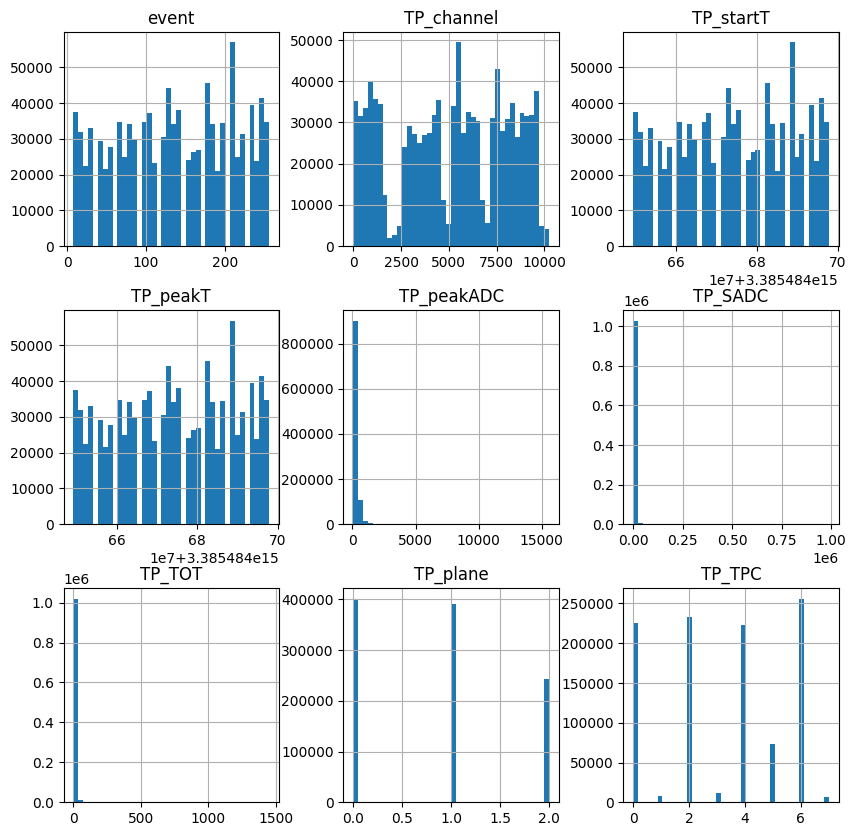

In [7]:
#Let's load the data from run 32974
df = load_data("data/pdhd_run032975_tps.root", TP_BRANCHES, 1000)
df.hist(figsize= (10,10), bins =40)
plt.show()

In [8]:
#Let's see what event IDs exist in the file
triggers = df.event.unique()
triggers

array([  8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96, 104,
       112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208,
       216, 224, 232, 240, 248, 256], dtype=uint32)

## Example event display

### Cosmic signals from the full PDHD detector. 

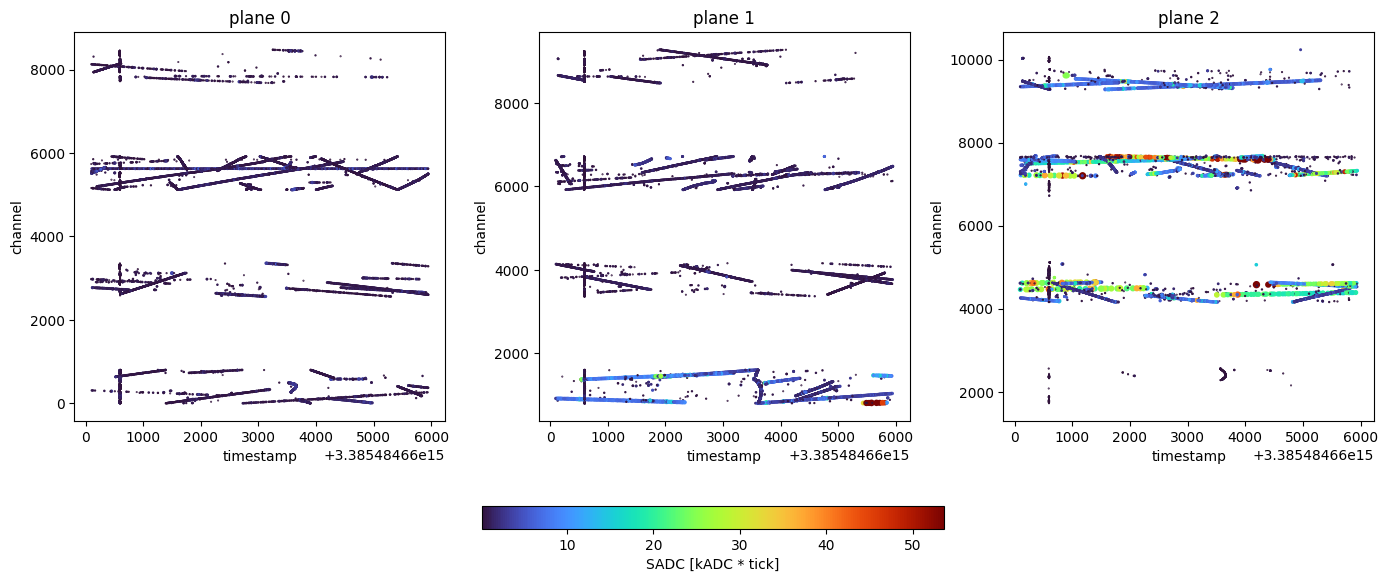

In [9]:

event = triggers[7]
tps_all = df[(df.event == event) & (df.TP_TOT > 1)]
vmin, vmax = tps_all["TP_SADC"].min()/1e3, (tps_all["TP_SADC"].max()/1e3)/2

fig, ax = plt.subplots(1, 3, figsize=(14, 6))

for plane in range(3):
    tps = tps_all[tps_all.TP_plane == plane]
    sc = ax[plane].scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='turbo', vmin=vmin, vmax=vmax)
    ax[plane].set_xlabel("timestamp")
    ax[plane].set_ylabel("channel")
    ax[plane].set_title(f"plane {plane}")

fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.05, pad=-0.3).set_label("SADC [kADC * tick]")
plt.tight_layout()
plt.show()


# Let's visualise the three planes from a single TPC to get some intuition about how tracks at different angles look in the various views 

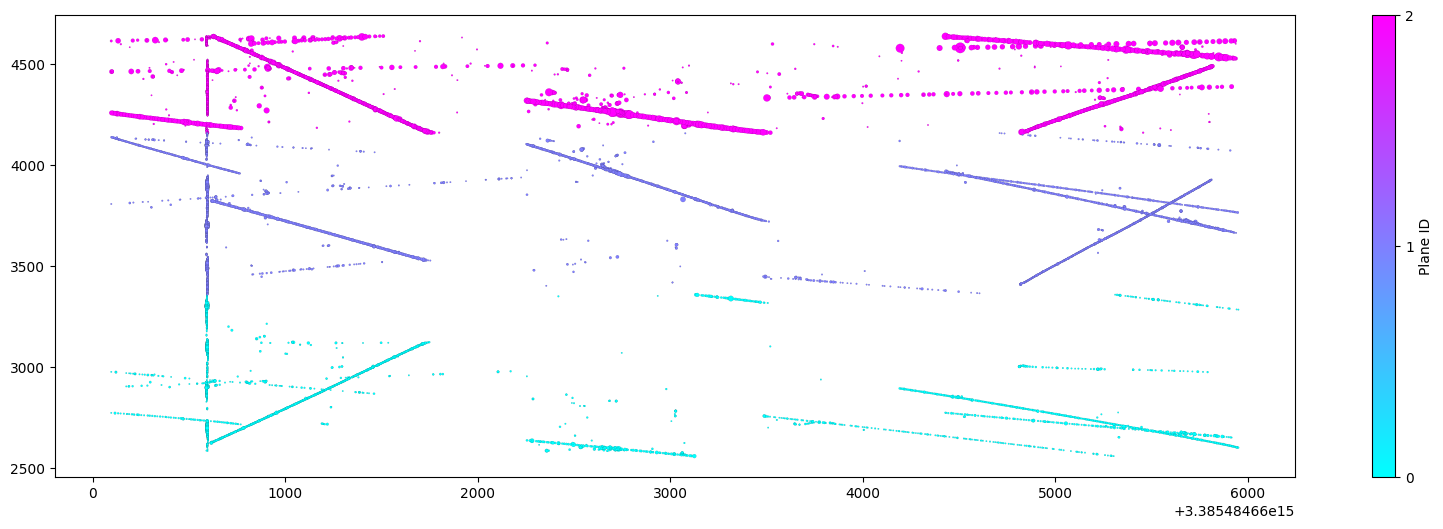

In [47]:
tps_all = df[(df.event == event) & (df.TP_TPC == 2)]

plt.figure(figsize=(20,6))
plt.scatter(tps_all.TP_peakT, tps_all.TP_channel, s= tps_all.TP_peakADC/50, c= tps_all.TP_plane, cmap='cool', edgecolor='k', linewidth=0.05)
cbar = plt.colorbar(ticks=[0,1,2])
cbar.set_label("Plane ID")
plt.show()